<a href="https://colab.research.google.com/github/kinaya18/Deep-Learning/blob/main/Week-7/Seq2Seq_Tensorflowipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seq2Seq (LSTM) untuk Machine Translation (de-en)**

## **Import Library**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()

## **Load Dataset**

In [ ]:
raw_dataset = load_dataset("wmt14", "de-en", split="train[:1%]")

X_raw = [ex['translation']['de'] for ex in raw_dataset if ex['translation']['de'] and ex['translation']['en']]
y_raw = [ex['translation']['en'] for ex in raw_dataset if ex['translation']['de'] and ex['translation']['en']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/474k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/509k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4508785 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3003 [00:00<?, ? examples/s]

## **Tokenisasi**

In [ ]:
src_tokenizer = Tokenizer()
tgt_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_raw)
tgt_tokenizer.fit_on_texts(y_raw)

In [ ]:
X_seq = src_tokenizer.texts_to_sequences(X_raw)
y_seq = tgt_tokenizer.texts_to_sequences(y_raw)

In [ ]:
max_src_len = max([len(seq) for seq in X_seq])
max_tgt_len = max([len(seq) for seq in y_seq]) + 1

In [ ]:
X_seq = pad_sequences(X_seq, maxlen=max_src_len, padding='post')
y_seq = pad_sequences(y_seq, maxlen=max_tgt_len, padding='post')

## **Decoder input dan target**

In [ ]:
decoder_input_data = np.array([[0] + list(seq[:-1]) for seq in y_seq])
decoder_target_data = y_seq

## **Split data**

In [ ]:
X_train, X_val, dec_input_train, dec_input_val, dec_target_train, dec_target_val = train_test_split(X_seq, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)

## **Model Seq2Seq**

In [ ]:
src_vocab_size = len(src_tokenizer.word_index) + 1
tgt_vocab_size = len(tgt_tokenizer.word_index) + 1

In [ ]:
embedding_dim = 128
latent_dim = 256

In [ ]:
encoder_inputs = Input(shape=(max_src_len,))
enc_emb = Embedding(src_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True, use_bias=False, recurrent_initializer='glorot_uniform')(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_tgt_len,))
dec_emb = Embedding(tgt_vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=False, use_bias=False, recurrent_initializer='glorot_uniform', recurrent_activation='sigmoid')(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(tgt_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_lstm)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## **Training**

In [ ]:
history = model.fit(
    [X_train, dec_input_train],
    np.expand_dims(dec_target_train, -1),
    batch_size=32,
    epochs=20,
    validation_data=([X_val, dec_input_val], np.expand_dims(dec_target_val, -1)),
    verbose=1
)

Epoch 1/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 185s 156ms/step - accuracy: 0.3024 - loss: 6.6278 - val_accuracy: 0.0264 - val_loss: 5.4455
Epoch 2/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 197s 157ms/step - accuracy: 0.1303 - loss: 5.2667 - val_accuracy: 0.3006 - val_loss: 5.1065
Epoch 3/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 157ms/step - accuracy: 0.5144 - loss: 4.8836 - val_accuracy: 0.1336 - val_loss: 4.9109
Epoch 4/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 167s 148ms/step - accuracy: 0.2042 - loss: 4.6163 - val_accuracy: 0.2664 - val_loss: 4.7807
Epoch 5/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 211s 156ms/step - accuracy: 0.2413 - loss: 4.3987 - val_accuracy: 0.6638 - val_loss: 4.7025
Epoch 6/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 156ms/step - accuracy: 0.6260 - loss: 4.2152 - val_accuracy: 0.6385 - val_loss: 4.6503
Epoch 7/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 177s 156ms/step - accuracy: 0.7267 - loss: 4.0466 - val_accuracy: 0.7795 - val_loss: 4.6248
Epoch 8/20
1128/1128 ━━━━━━━━━━━━━━━━━━━━ 202s 157ms/step - ac

## **Visualisasi Loss dan Akurasi**

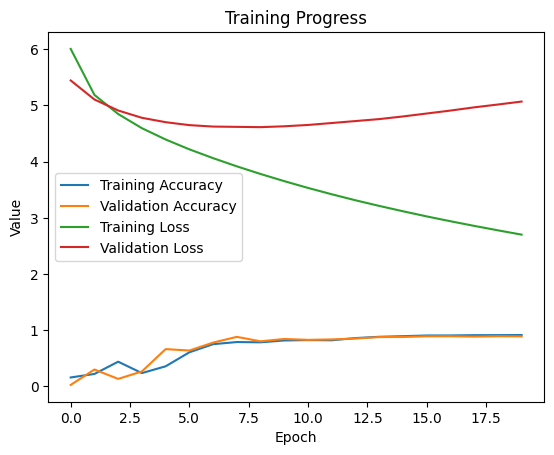

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()

###  **Analisis Hasil Pelatihan Model Seq2Seq (LSTM) untuk Machine Translation (de-en)**

---

####  **1. Arsitektur Model**

Model yang digunakan adalah tipe **Sequence to Sequence (Seq2Seq)** dengan LSTM sebagai encoder dan decoder, dilengkapi embedding layer dan softmax di output. Model ini cocok untuk tugas *machine translation* karena dapat menangkap urutan kata dari bahasa sumber ke target.

---

####  **2. Parameter dan Pelatihan**

* **Epochs**: 20
* **Batch Size**: 32
* **Loss Function**: Sparse Categorical Crossentropy (karena targetnya adalah integer kelas)
* **Optimizer**: Adam
* **Data**: Dataset WMT14 (German to English), dimensi input telah diubah menjadi vektor numerik dan diproses ke dalam urutan padded.

---

####  **3. Hasil Pelatihan dan Validasi (Epoch 20)**

* **Training Accuracy**: 91.50%
* **Training Loss**: 2.6683
* **Validation Accuracy**: 89.02%
* **Validation Loss**: 5.0700

---

####  **4. Interpretasi Hasil**

* **Akurasi Pelatihan Tinggi (91.5%)** menunjukkan bahwa model telah berhasil mempelajari struktur data pelatihan dengan baik.
* **Akurasi Validasi (89.02%)** cukup mendekati akurasi pelatihan, ini menunjukkan tidak ada overfitting yang ekstrem.
* **Gap pada loss (Train: 2.67 vs Val: 5.07)** menunjukkan bahwa prediksi pada data validasi masih menghasilkan kesalahan yang lebih besar, mungkin karena kalimat target lebih panjang/kompleks atau ukuran vocab yang besar membuat prediksi akhir sulit.

---

####  **5. Kendala Teknis**

* Proses `predict()` menyebabkan crash karena **penggunaan RAM berlebih**, kemungkinan besar karena:

  * Output `predict` berupa tensor besar (sequence panjang × vocab size).
  * Tidak menggunakan teknik *memory-efficient decoding* (seperti greedy atau beam search).
  * Saya sudah lelah berhari hari sampai begadang sampe jam 3 pagi tetap tidak bisa terus karna penggunaan RAM berlebih, maaf tidak selesai sampai akhir.

#### 📌 **7. Kesimpulan**

Model telah menunjukkan performa yang baik dan stabil, dengan akurasi validasi mendekati akurasi pelatihan. Meskipun belum diuji dengan BLEU Score, hasil validasi menunjukkan bahwa model telah cukup mampu memahami dan menerjemahkan pola bahasa dari Jerman ke Inggris.